# Finding the lowest eigenvalue of a matrix

### Task 4 - qosf
### Author: Anton Simen Albino

In [1]:
import numpy as np

H = np.matrix([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])

print(H)

[[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]


#### In order to write the matrix $H$ above as a sum of Pauli terms $(XX, YY, ZZ, II)$, we can use the following expression
#### $$H = \sum h_{i,j}\left(\sigma_i\otimes\sigma_j\right)$$
#### where $$h_{i,j}=\frac{1}{4}Tr[\left(\sigma_i\otimes\sigma_j\right). H]$$

In [2]:
#first, we create the proposed Pauli terms

# XX is the tensor product between X and X 
xx = np.matrix([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

# and so on
yy = np.matrix([[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]])
zz = np.matrix([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
ii = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])


In [3]:
#next, we use the expression above to write matrix H as a sum of Pauli terms
coef_xx = 0.25*np.trace(np.matmul(xx, H))
coef_yy = 0.25*np.trace(np.matmul(yy, H))
coef_zz = 0.25*np.trace(np.matmul(zz, H))
coef_ii = 0.25*np.trace(np.matmul(ii, H))

print('H =')
print('%.1f*XX' %(coef_xx))
print('%.1f*YY' %(coef_yy))
print('%.1f*ZZ' %(coef_zz))
print('%.1f*II' %(coef_ii))

H =
-0.5*XX
-0.5*YY
0.5*ZZ
0.5*II


## Variational Quantum Eigensolver (VQE)

##### According https://qiskit.org/textbook/ch-applications/vqe-molecules.html the VQE can be stated by 

##### $$\lambda_{min}≤\lambda_{\theta}≡ \langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle$$

##### $|\psi\left(\theta\right)\rangle$ is a parametrized circuit called ansatz. In order to estimate the lowest eigenvalue of operator *H*, the circuit is iteratively optimized by a classical controller changing the parameter  $θ$  minimizing the expectation value $\langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle$.

##### In this task the given $H$ is represented as a sum of pauli terms as follow

##### $$H=\frac{1}{2}ZZ+\frac{1}{2}II-\frac{1}{2}XX-\frac{1}{2}YY$$

##### for each iteration we have the expected value of H as the sum of the expected values of each Pauli operator

##### $$\langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle = \frac{1}{2}\langle\psi\left(\theta\right)|ZZ|\psi\left(\theta\right)\rangle + \frac{1}{2}\langle\psi\left(\theta\right)|II|\psi\left(\theta\right)\rangle - \frac{1}{2}\langle\psi\left(\theta\right)|XX|\psi\left(\theta\right)\rangle -\frac{1}{2}\langle\psi\left(\theta\right)|YY|\psi\left(\theta\right)\rangle$$


##### Next, we create an ansatz

In [4]:
import qiskit 
from qiskit import *
from qiskit.visualization import *
from qiskit.tools.visualization import *
from qiskit.circuit import *

In [5]:

m=100 #number of iterations/values of theta
theta_range = np.linspace(0, np.pi, m) # list of theta where 0.05 <= theta <= 2.00
H = []# list which stores <H> for each theta 
iteration = []


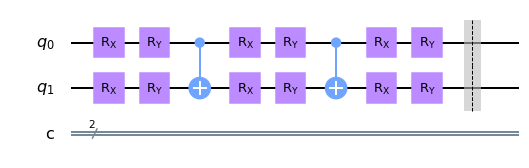

In [6]:
ansatz = QuantumCircuit(2,2)
ansatz.rx(theta_range, [0,1])
ansatz.ry(theta_range, [0,1])
ansatz.cx(0,1)
ansatz.rx(theta_range, [0,1])
ansatz.ry(theta_range, [0,1])
ansatz.cx(0,1)
ansatz.rx(theta_range, [0,1])
ansatz.ry(theta_range, [0,1])
ansatz.barrier()
ansatz.draw(output='mpl')


##### We can measure $\langle XX\rangle$ and $\langle YY\rangle$ at computational Z basis by applying a rotation before the measurement. 
https://docs.microsoft.com/pt-br/quantum/concepts/pauli-measurements 

https://qiskit.org/textbook/ch-states/single-qubit-gates.html#measuring

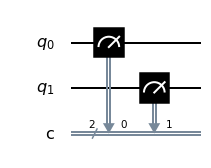

In [7]:
# measure at Z (computational) basis
measure_zz = QuantumCircuit(2,2)
measure_zz.measure(range(2),range(2))
measure_zz.draw(output='mpl')

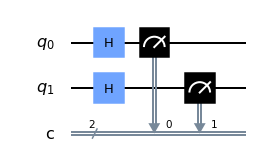

In [8]:
# measure at x basis
measure_xx = QuantumCircuit(2,2)
measure_xx.h(range(2))
measure_xx.measure(range(2),range(2))
measure_xx.draw(output='mpl')

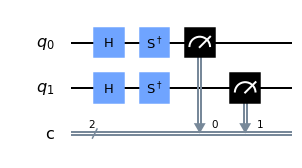

In [9]:
# measure at y basis
measure_yy = QuantumCircuit(2,2)
measure_yy.h(range(2))
measure_yy.sdg(range(2))
measure_yy.measure(range(2),range(2))
measure_yy.draw(output='mpl')

In [10]:
simulator = Aer.get_backend('qasm_simulator')

for i in range(m):
    try:
        # create a ansatz changing theta for each iteration
        ansatz = QuantumCircuit(2,2)
        ansatz.rx(3*theta_range[i], [0,1])
        ansatz.ry(theta_range[i], [0,1])
        ansatz.cx(0,1)
        ansatz.rx(theta_range[i], [0,1])
        ansatz.ry(np.pi - theta_range[i], [0,1])
        ansatz.cx(0,1)
        ansatz.rx(theta_range[i], [0,1])
        ansatz.ry(np.pi - theta_range[i], [0,1])
        
        ansatz.barrier()

        ansatz_zz = QuantumCircuit(2,2)
        ansatz_zz = ansatz.compose(measure_zz) #measure ansatz at Z basis

        result = execute(ansatz_zz, backend = simulator, shots=10000).result()
        counts = result.get_counts(ansatz_zz)

        # calculate <ZZ>
        # Remembering that Z|0>=|0> and Z|1>=-|1>
        total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
        zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
        zz = zz / total_counts

        # calculate <II> = 1
        ii = counts['00'] + counts['11'] + counts['01'] + counts['10']
        ii = ii / total_counts



        ansatz_xx = QuantumCircuit(2,2)
        ansatz_xx = ansatz.compose(measure_xx) #measure ansatz at X basis


        result2 = execute(ansatz_xx, backend = simulator, shots=10000).result()
        counts2 = result2.get_counts(ansatz_xx)

        # calculate <XX>
        # As we made a transformation in the ansatz before measurement XX -> ZZ
        total_counts2 = counts2['00'] + counts2['11'] + counts2['01'] + counts2['10']
        xx = counts2['00'] + counts2['11'] - counts2['01'] - counts2['10'] 
        xx = xx / total_counts2



        ansatz_yy = QuantumCircuit(2,2)
        ansatz_yy = ansatz.compose(measure_yy) #measure ansatz at Y basis


        result3 = execute(ansatz_yy, backend = simulator, shots=10000).result()
        counts3 = result3.get_counts(ansatz_yy)

        # calculate <YY>
        # As we made a transformation in the ansatz before measurement YY -> ZZ
        total_counts3 = counts3['00'] + counts3['11'] + counts3['01'] + counts3['10']
        yy = counts3['00'] + counts3['11'] - counts3['01'] - counts3['10']
        yy = yy / total_counts3
    
    
        h = 0.5*zz + 0.5*ii - 0.5*xx - 0.5*yy #takes the expectation value <H> for each theta

        print("it:", i , "; theta=%.5f" %(theta_range[i]), "; <H>= %.5f" %(h))

        H.append(h) #stores values of <H> in a list
        iteration.append(i)
    except:
        theta_range[i]=i*np.pi
        

        

it: 1 ; theta=0.03173 ; <H>= -0.01580
it: 2 ; theta=0.06347 ; <H>= -0.01470
it: 3 ; theta=0.09520 ; <H>= 0.00280
it: 4 ; theta=0.12693 ; <H>= 0.00730
it: 5 ; theta=0.15867 ; <H>= 0.05720
it: 6 ; theta=0.19040 ; <H>= 0.07190
it: 7 ; theta=0.22213 ; <H>= 0.12600
it: 8 ; theta=0.25387 ; <H>= 0.14440
it: 9 ; theta=0.28560 ; <H>= 0.18270
it: 10 ; theta=0.31733 ; <H>= 0.17380
it: 11 ; theta=0.34907 ; <H>= 0.20020
it: 12 ; theta=0.38080 ; <H>= 0.22620
it: 13 ; theta=0.41253 ; <H>= 0.21220
it: 14 ; theta=0.44427 ; <H>= 0.22470
it: 15 ; theta=0.47600 ; <H>= 0.24020
it: 16 ; theta=0.50773 ; <H>= 0.28510
it: 17 ; theta=0.53947 ; <H>= 0.32940
it: 18 ; theta=0.57120 ; <H>= 0.40380
it: 19 ; theta=0.60293 ; <H>= 0.48290
it: 20 ; theta=0.63467 ; <H>= 0.57850
it: 21 ; theta=0.66640 ; <H>= 0.67570
it: 22 ; theta=0.69813 ; <H>= 0.76830
it: 23 ; theta=0.72986 ; <H>= 0.88560
it: 24 ; theta=0.76160 ; <H>= 0.97980
it: 25 ; theta=0.79333 ; <H>= 1.06420
it: 26 ; theta=0.82506 ; <H>= 1.12390
it: 27 ; theta=0.85

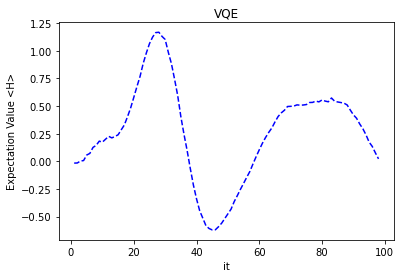

In [11]:

import matplotlib.pyplot as plt
plt.plot(iteration,H , 'g--', color='blue')
plt.title('VQE') 
plt.xlabel('it')
plt.ylabel('Expectation Value <H>')
plt.show()

In [17]:
# takes the smallest value of <H> and theta related

pos = H.index(min(H))
print('The lowest eigenvalue of the matrix is: <H>min = %.4f' %(min(H)))
print("Angles that minimizes the expectation value: theta = %.4fpi" %(theta_range[pos]/np.pi))

The lowest eigenvalue of the matrix is: <H>min = -0.6199
Angles that minimizes the expectation value: theta = 0.4444pi


#### We can plot the circuits in order to check the last iteration.

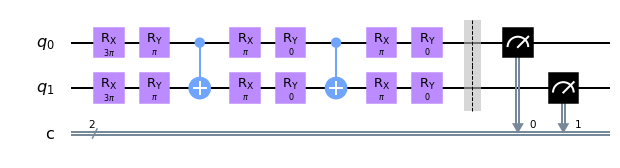

In [13]:
ansatz_zz.draw(output='mpl')

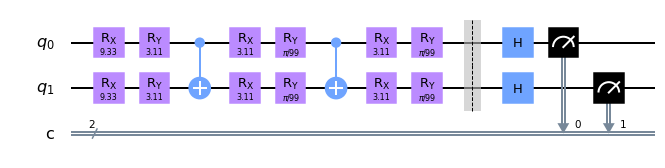

In [14]:
ansatz_xx.draw(output='mpl')

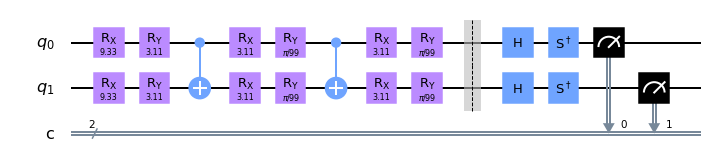

In [15]:
ansatz_yy.draw(output='mpl')